# Exploring & Testing Use of NURBS in DIC
## Sam Potter
## Current: 2/15/19

## Path and Imports

In [1]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
import warnings
from dic import nurbs
from dic import fileIO
from dic import numerics
from dic import analysis
from dic import image_processing
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from geomdl import BSpline as bs
from geomdl import utilities as gutil
from geomdl import helpers
import scipy.optimize as sciopt
import scipy.signal as sig

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DOA_cropped_gray_pad_0.tiff'
dic_name = '/workspace/stpotter/git/bitbucket/dic/data/DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = '/workspace/stpotter/git/bitbucket/dic/data/DOSA_cropped_gray_pad_0.tiff'
def_image = cv2.imread(dic_name, -1)  # Read in image 'as is'
def_image = def_image.astype('uint8')

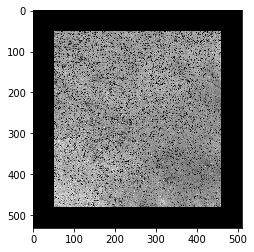

In [4]:
# Display
plt.imshow(def_image, cmap='gray')

## Deform Ref Image

In [5]:
# Translate image
dx = 0.0
dy = 0.0
f11 = 1.01
f12 = 0.0
f21 = 0.0
f22 = 1.0
f = np.array([[f11, f12],
             [f21, f22]])
finv = np.linalg.inv(f)
f11i = finv[0, 0]
f12i = finv[0, 1]
f21i = finv[1, 0]
f22i = finv[1, 1]
transx = np.array([[f11i, f12i, dx],
                   [f21i, f22i, dy]])
ref_image = image_processing.im_warp(def_image, transx)

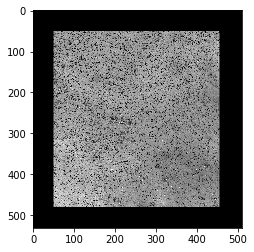

In [6]:
# Display
plt.imshow(ref_image, cmap='gray')

## Manually Specify Region of Interest

In [7]:
# Format: [column index for start of X, column index for end of X, row index for start of Y, row index for end of Y]
subregion_indices = np.array([125, 375, 125, 375])

## Setup reference mesh

In [8]:
# Control Points
rowmin = subregion_indices[-2:].min()
rowmax = subregion_indices[-2:].max()
colmin = subregion_indices[:2].min()
colmax = subregion_indices[:2].max()
x = np.linspace(colmin, colmax, 4)
y = np.linspace(rowmin, rowmax, 4)
coords = np.zeros((len(x) * len(y), 2))
k = 0
for i in range(0, len(x)):
    for j in range(0, len(y)):
        coords[k, :] = np.array([x[i], y[j]])
        k += 1

In [9]:
# Surface
ref_surf = bs.Surface()

ref_surf.degree_u = 3
ref_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords)).astype('int')

ref_surf.set_ctrlpts(coords.tolist(), num_ctrlpts, num_ctrlpts)

ref_surf.knotvector_u = gutil.generate_knot_vector(ref_surf.degree_u, num_ctrlpts)
ref_surf.knotvector_v = gutil.generate_knot_vector(ref_surf.degree_v, num_ctrlpts)

ref_surf.delta = 0.01

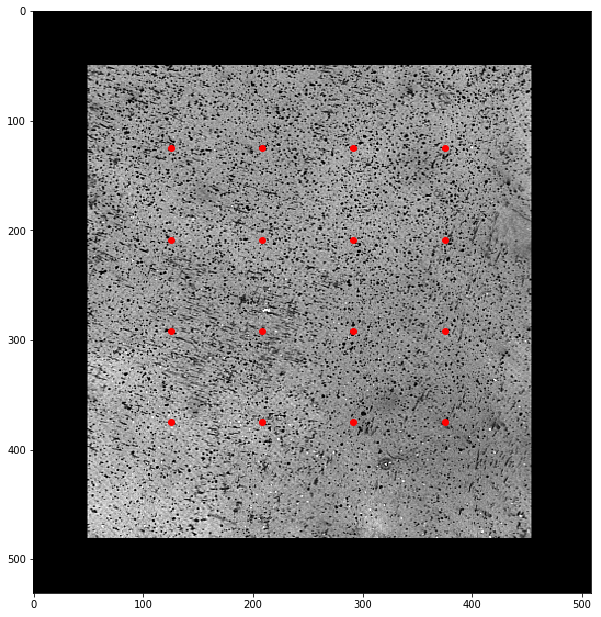

In [10]:
# Plot the mesh nodes on the original image
# Would be nice to be able to visualize full mesh
x = coords[:, 0]
y = coords[:, 1]
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_image, cmap='gray')
ax.plot(x, y, 'o', color='red')
plt.show()

## Test Synthetically Deforming Ctrlpts

In [11]:
F = np.array([[f11, f12],
             [f21, f22]])

coords_new = np.zeros((len(coords), 2))

for i in range(len(coords_new)):
    coords_new[i, :] = np.matmul(F, coords[i, :]) + np.array([dx, dy])

In [12]:
# Set up new surface
disp_surf = bs.Surface()

disp_surf.degree_u = 3
disp_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords_new)).astype('int')

disp_surf.set_ctrlpts(coords_new.tolist(), num_ctrlpts, num_ctrlpts)

disp_surf.knotvector_u = gutil.generate_knot_vector(disp_surf.degree_u, num_ctrlpts)
disp_surf.knotvector_v = gutil.generate_knot_vector(disp_surf.degree_v, num_ctrlpts)

disp_surf.delta = 0.01

In [13]:
# Compute control point displacements
coords_disp = coords_new - coords
synth_disp = np.ndarray.flatten(coords_disp)

# Compute mesh_znssd
analysis.mesh_znssd(ref_image, def_image, ref_surf, coords_disp)

149.09911323067746

In [29]:
coords_new

array([[126.25      , 125.        ],
       [126.25      , 208.33333333],
       [126.25      , 291.66666667],
       [126.25      , 375.        ],
       [210.41666667, 125.        ],
       [210.41666667, 208.33333333],
       [210.41666667, 291.66666667],
       [210.41666667, 375.        ],
       [294.58333333, 125.        ],
       [294.58333333, 208.33333333],
       [294.58333333, 291.66666667],
       [294.58333333, 375.        ],
       [378.75      , 125.        ],
       [378.75      , 208.33333333],
       [378.75      , 291.66666667],
       [378.75      , 375.        ]])

## Pack necessary arguments into a tuple

In [14]:
arg_tup = (ref_image, def_image, ref_surf)

## Write minfun to pass to scipy optimize

In [15]:
def minfun_nm(disp_vec, *args):
    
    '''
    Minimizatin function for passing to scipy minimize using Nelder-Mead method
    
    Assembles solution vector and arguments, then passes to mesh_znssd to compute cost
    
    :param disp_vec: trial displacement vector. Shape is (1, 2*num_ctrltps) and is orderd
    [delta x0, delta y0, delta x1, delta y1, etc.]
    :type disp_vec: ndarray
    return: scalar value of mesh znssd at the trial displacement vector
    :rtype: float
    '''
       
    # Assemble displacement vector
    ctrlpt_disp = np.zeros((int(len(disp_vec)/2), 2))
    for i in range(0, len(disp_vec), 2):
        k = i // 2  # Modulo to keep the index from over running length of ctrlpt_disp
        ctrlpt_disp[k, :] = np.array([disp_vec[i], disp_vec[i + 1]])
        
    # Call znssd with defaults on all keyward params. This will make it a bit slower, but whatever for now
    znssd = analysis.mesh_znssd(*args, ctrlpt_disp)
    
    # print(znssd)
    
    return znssd
    

In [16]:
# # Call back

# def callback_mesh():

#     pass

## Wrap this minfun in scipy optimization library

In [17]:
# Compute rigid initial correlation with 2d correlation
rowmid = int(np.mean([rowmin, rowmax]))
colmid = int(np.mean([colmin, colmax]))

# Get subimage
subimage = np.copy(ref_image[subregion_indices[2]:subregion_indices[3], subregion_indices[0]:subregion_indices[1]])

# Normalize images
ref_subnorm = subimage - subimage.mean()
def_norm = def_image - def_image.mean()

# Correlate
corr = sig.correlate2d(def_norm, ref_subnorm, boundary='symm', mode='same')
midy, midx = np.unravel_index(np.argmax(corr), corr.shape)

initx = (midx + 1) - colmid
inity = (midy + 1) - rowmid

# Setup initial displacement vector
int_disp_vec = np.zeros(2*len(coords))
for i in range(0, len(int_disp_vec), 2):
    int_disp_vec[i] = initx
    int_disp_vec[i+1] = inity

# compute mesh znssd one time and exit if its low enough

residual = minfun_nm(int_disp_vec, *arg_tup)

if residual > 1e-6:
    print('Begin minimization')
    result = sciopt.minimize(minfun_nm, int_disp_vec, args=arg_tup, method='L-BFGS-B', jac='2-point', bounds=None, options={'maxiter': 10, 'disp': True})

print('Actual Rigid X Displacement: {}'.format(dx))
print('Actual Rigid Y Displacement: {}'.format(dy))
print('Mesh Details: {} by {}'.format(num_ctrlpts, num_ctrlpts))
print('Initial Guess -  X Displacement: {}'.format(initx))
print('Initial Guess - Y Displacement: {}'.format(inity))

if residual > 1e-6:
    print('residual')
    print(result.fun)
    print('final control point displacements')
    print(result.x)
else:
    print('residual')
    print(residual)
    print('final control point displacement')
    print(int_disp_vec)

Begin minimization
Actual Rigid X Displacement: 0.0
Actual Rigid Y Displacement: 0.0
Mesh Details: 4 by 4
Initial Guess -  X Displacement: 2
Initial Guess - Y Displacement: 0
residual
150.8475053234094
final control point displacements
[ 1.24445020e+00  6.38812736e-03  1.25750282e+00 -1.17140239e-03
  1.26673685e+00  4.31404406e-03  1.25924346e+00  1.88279449e-03
  2.08078970e+00  5.40787369e-03  2.06402332e+00  4.94853890e-03
  2.06410678e+00  3.69479922e-03  2.06238650e+00  9.76311983e-03
  2.93880140e+00  1.53600397e-03  2.91983108e+00  1.85022147e-03
  2.92819188e+00  2.66529332e-03  2.93232084e+00 -1.79934029e-03
  3.74096395e+00  6.15591537e-03  3.73523129e+00 -2.07685630e-03
  3.75271689e+00  7.97121279e-03  3.74559503e+00 -7.15830327e-03]


## Visualize displacement results

In [18]:
# Create control point displacement vectors from minimization results
disp_cpts = np.column_stack((int_disp_vec[::2], int_disp_vec[1::2]))

In [19]:
# Set up new surface
disp_surf = bs.Surface()

disp_surf.degree_u = 3
disp_surf.degree_v = 3

#num_ctrlpts = np.sqrt(len(disp_cpts)).astype('int')

#disp_surf.set_ctrlpts(disp_cpts.tolist(), num_ctrlpts, num_ctrlpts)

disp_surf.set_ctrlpts(coords_disp.tolist(), num_ctrlpts, num_ctrlpts)

disp_surf.knotvector_u = gutil.generate_knot_vector(disp_surf.degree_u, num_ctrlpts)
disp_surf.knotvector_v = gutil.generate_knot_vector(disp_surf.degree_v, num_ctrlpts)

disp_surf.delta = 0.01

In [20]:
# Fill x and y displacement arrays
U = np.zeros(ref_image.shape) * np.nan
V = np.zeros(ref_image.shape) * np.nan

for i in range(rowmin, rowmax):
    for j in range(colmin, colmax):
        u_val = (j - colmin) / (colmax - colmin)
        v_val = (i - rowmin) / (rowmax - rowmin)
        disp = disp_surf.surfpt(u_val, v_val)
        U[i, j] = disp[0]
        V[i, j] = disp[1]
        

Text(0.5, 1.0, 'Y Displacement (Pixels)')

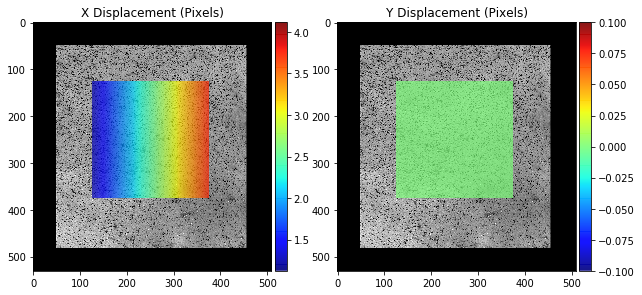

In [34]:
# Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(ref_image, cmap='gray')
Uim = ax0.imshow(U, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Uim, cax=cax0)
Umin = 0.9 * np.nanmin(U)
Umax = 1.1 * np.nanmax(U)
Uim.set_clim(Umin, Umax)
ax0.set_title('X Displacement (Pixels)')

im1 = ax1.imshow(ref_image, cmap='gray')
Vim = ax1.imshow(V, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Vim, cax=cax1)
Vmin = 0.9 * np.nanmin(V)
Vmax = 0.9 * np.nanmax(V)
Vim.set_clim(Vmin, Vmax)
ax1.set_title('Y Displacement (Pixels)')

## Visualize deformation results

In [23]:
# Function to compute J^-1

def jac_inv(surf, u, v):
    
    '''
    Compute inverse of jacobian given a NURBS surface and u, v parametric coordinates
    
    :param surf: NURBS surface
    :type surf: NURBS surface object
    :param u: u parametric location
    :type u: float
    :param v: v parametric location
    :type v: float
    :returns: computed inverse jacobian
    :rtype: ndarray
    '''
    
    # Prefill matrix
    matrix = np.zeros((2, 2))
    
    # Compute surface derivatives
    derivs = surf.tangent((u, v), normalize=False)
    
    # Fill matrix
    # x1_u
    matrix[0, 0] = derivs[1][0]
    # x1_v
    matrix[0, 1] = derivs[1][1]
    # x2_u
    matrix[1, 0] = derivs[2][0]
    # x2_v
    matrix[1, 1] = derivs[2][1]
    
    # Compute inverse
    inv = np.linalg.inv(matrix)
    
    return inv


# Function to compute R_u (passing params for now, may not be faster? Better way to avoid . methods?)

def R_u(deg_u, deg_v, kvec_u, kvec_v, span_u, span_v, u, v):
    
    '''
    Compute the partial derivative of the surface basis function wrt parametric coordinates
    
    See Piegl & Tiller Eq. 3.17 for reference
    
    :param deg_u: degree of basis functions in u direction
    :type deg_u: int
    :param deg_v: degree of basis functions in v direction
    :type deg_v: int
    :param kvec_u: knot vector in u direction
    :type kvec_u: ndarray
    :param kvec_v: knot vector in v direction
    :type kvec_v: ndarray
    :param span_u: basis function number in u direction
    :type span_u: int
    :param span_v: basis function number in v direction
    :type span_v: int
    :param u: u parametric coordinate
    :type u: float
    :param v: v parametric coordinate
    :type v: float
    '''
      
    # protoype function calls
    basis_der = helpers.basis_function_ders_one
    basis_one = helpers.basis_function_one
    
    # Get u derivative
    deriv_u = basis_der(deg_u, kvec_u, span_u, u, 1)[1] * basis_one(deg_v, kvec_v, span_v, v)
    
    # Get v derivative
    deriv_v = basis_one(deg_u, kvec_u, span_u, u) * basis_der(deg_v, kvec_v, span_v, v, 1)[1]
    
    return np.array([deriv_u, deriv_v])


# Function to compute F (vectorizable?)

def def_grad(surf, u, v, disp_vec):
    
    '''
    Compute the components of the spatial derivatives of a NURBS mesh at a u, v location
    
    :param surf: NURBS surface on which to compute spatial derivatives
    :type surf: NURBS surface object
    :param u: u parametric coordinate
    :type u: float
    :param v: v parametric coordinate
    :type v: float
    :param disp_vec: array of control point displacements [delta x, delta y]
    :type disp_vec: ndarray
    :return: vector containing spatial derivatives of the NURBS surface evaluated at that coordinate location
    '''
    
    # Compute J^-1
    Jinv = jac_inv(surf, u, v)
    
    # Pull out surface info
    deg_u = surf.degree_u
    deg_v = surf.degree_v
    kvec_u = surf.knotvector_u
    kvec_v = surf.knotvector_v
    ctrl_u = surf.ctrlpts_size_u
    ctrl_v = surf.ctrlpts_size_v
    
    F = np.zeros((2, 2))
    k = 0
    
    for spanu in range(0, ctrl_u):
        for spanv in range(0, ctrl_v):
            
            # Compute parametric derivatives
            dRdu = R_u(deg_u, deg_v, kvec_u, kvec_v, spanu, spanv, u, v)
            
            # Multiply with J^-1
            dRdx = np.matmul(dRdu, Jinv)
            
            # Fill F
            F[0, 0] += dRdx[0] * disp_vec[k, 0]  # d delta x1 dx1
            F[0, 1] += dRdx[1] * disp_vec[k, 0]  # d delta x1 dx2
            F[1, 0] += dRdx[0] * disp_vec[k, 1]  # d delta x2 dx1
            F[1, 1] += dRdx[1] * disp_vec[k, 1]  # d delta x2 dx2
            
            # Bump incrementer
            k += 1
    
    # Add identity tensor
    F += np.eye(2)
            
    return F

            

In [24]:
def_grad(ref_surf, 0.5, 0.5, coords_disp)

array([[1.01, 0.  ],
       [0.  , 1.  ]])

In [25]:
# Surface approach
def def_grad_surf(surf, u, v):
    
    '''
    Compue deformation gradient via a NURBS surface interpolation of control point displacement at u, v parametric coordinates
    
    :param surf: NURBS surface interpolating control point displacements
    :type surf: NURBS surface object
    :param u: u parametric location
    :type u: float
    :param v: v parametric location
    :type v: float
    :returns: computed inverse jacobian
    :rtype: ndarray
    '''
    
    F = np.zeros((2, 2))
    
    tangents = surf.tangent((u, v), normalize=False)
    
    F[0, 0] = 1 + tangents[1][0]  # d delta x1 dx1
    F[0, 1] = tangents[1][1]  # d delta x1 dx2
    F[1, 0] = tangents[2][1]  # d delta x2 dx1
    F[1, 1] = 1 + tangents[2][1]  # d delta x2 dx2
    
    return F
    

In [26]:
def_grad_surf(disp_surf, .8, 0.5)

array([[3.5, 0. ],
       [0. , 1. ]])

In [51]:
# Fill x and y displacement arrays
F11 = np.zeros(ref_image.shape) * np.nan
F12 = np.zeros(ref_image.shape) * np.nan
F21 = np.zeros(ref_image.shape) * np.nan
F22 = np.zeros(ref_image.shape) * np.nan

for i in range(rowmin, rowmax):
    for j in range(colmin, colmax):
        u_val = (j - colmin) / (colmax - colmin)
        v_val = (i - rowmin) / (rowmax - rowmin)
        #F = def_grad_surf(disp_surf, u_val, v_val)
        F = def_grad(ref_surf, u_val, v_val, coords_disp)
        F11[i, j] = F[0, 0]
        F12[i, j] = F[0, 1]
        F21[i, j] = F[1, 0]
        F22[i, j] = F[1, 1]

Text(0.5, 1.0, 'F22')

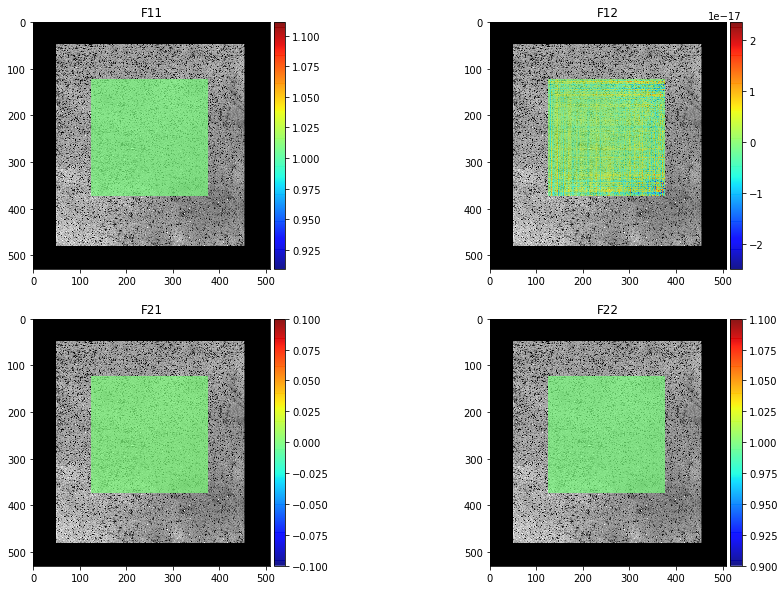

In [65]:
# Display
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15, 10))

im0 = ax0.imshow(ref_image, cmap='gray')
F11im = ax0.imshow(F11, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F11im, cax=cax0)
F11min = 0.9 * np.nanmin(F11)
F11max = 1.1 * np.nanmax(F11)
F11im.set_clim(F11min, F11max)
ax0.set_title('F11')

im1 = ax1.imshow(ref_image, cmap='gray')
F12im = ax1.imshow(F12, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F12im, cax=cax1)
F12min = 0.9 * np.nanmin(F12)
F12max = 1.1 * np.nanmax(F12)
F12im.set_clim(F12min, F12max)
ax1.set_title('F12')

im2 = ax2.imshow(ref_image, cmap='gray')
F21im = ax2.imshow(F21, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F21im, cax=cax2)
F21min = 0.9 * np.nanmin(F21)
F21max = 1.1 * np.nanmax(F21)
F21im.set_clim(F21min, F21max)
ax2.set_title('F21')

im3 = ax3.imshow(ref_image, cmap='gray')
F22im = ax3.imshow(F22, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F22im, cax=cax3)
F22min = 0.9 * np.nanmin(F22)
F22max = 1.1 * np.nanmax(F22)
F22im.set_clim(F22min, F22max)
ax3.set_title('F22')

In [66]:
F11[250, 250]

1.01

In [68]:
F22[250, 250]

1.0